<a href="https://colab.research.google.com/github/ayushsainime/BYTE2BEAT_HACKATHON/blob/main/the_eye_heart_connection_BYTE2BEAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
##  MOUNTING THE DRIVE AND WORKING DIRECTORY , LOADING  THE DATASET


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os
print( os.getcwd())

print( os.chdir('/content/drive/MyDrive/BYTE2BEAT'))

print( os.getcwd())

!mkdir -p ~/.kaggle
# 3. Copy the persistent file from Drive back to the system folder
!cp "/content/drive/MyDrive/BYTE2BEAT/kaggle.json" ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API is ready!")


Mounted at /content/drive
/content
None
/content/drive/MyDrive/BYTE2BEAT
Kaggle API is ready!


In [ ]:
# the dataset was uploaded to  google drive to avoid the repeated downloading whenever the session resets ,
# the current working directory is
print( os.getcwd())
# location of the datset is -
print( os.path.abspath("odir_data"))

/content/drive/MyDrive/BYTE2BEAT
/content/drive/MyDrive/BYTE2BEAT/odir_data



---

## LIBRARIES AND PREREQUISITES

In [ ]:
## import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random


# For Regularization (L2)
# In PyTorch, L2 is handled inside the optimizer as 'weight_decay'

# For Image Preprocessing (The ImageDataGenerator replacement)


print("GPU is available" if torch.cuda.is_available() else "GPU is not available")

dalton = 0

if torch.cuda.is_available() :
  dalton = 1
  device = torch.device( 'cuda')
else :
  dalton = 0
  device = torch.device( 'cpu')

print( f" dalton is {dalton}")

GPU is not available
 dalton is 0


In [ ]:
data_path =  os.path.abspath("odir_data")
print( data_path)

/content/drive/MyDrive/BYTE2BEAT/odir_data


---
## CHECKING  AND LOADING DATASET

In [ ]:
print(f"Dataset location: {data_path}")

Dataset location: /content/drive/MyDrive/BYTE2BEAT/odir_data


In [ ]:
print( os.listdir( data_path))

['ODIR-5K', 'full_df.csv', 'preprocessed_images']


In [ ]:
import os
file_path = os.path.join( data_path , 'full_df.csv')

df = pd.read_csv( file_path)

---
## SORTING THE REQUIRED IMAGES

the key  worrd that we are looking for is - "hypertensive retinopathy"

which is  hypertension noted in the eye .


In [ ]:
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [ ]:
# making the data that shows us the images (  eyes which have  hypertension )
def hypertension( text )  :
  if "hypertensive retinopathy" in text :
    return 1
  else :
    return 0

#print( df['H'].value_counts())

df['left_hypertension'] =  df['Left-Diagnostic Keywords'].apply( lambda  x : hypertension(x ))
df['right_hypertension'] =  df['Right-Diagnostic Keywords'].apply( lambda  x : hypertension(x ))

#print ( df['left_hypertension'].value_counts())
#print ( df['right_hypertension'].value_counts())


# we will find out the image swhich have hypertension problelms and are labelled as H = 1

left_hyper_images =  df.loc[(df['H'] == 1 ) & ( df['left_hypertension'] == 1 )]['Left-Fundus'].values
#print( left_hyper_images)
right_hyper_images =  df.loc[(df['H'] == 1 ) & ( df['right_hypertension'] == 1 )]['Right-Fundus'].values
#print( right_hyper_images)


# now the normal eyes

left_normal = df.loc[(df['H']  == 0 )&( df['Left-Diagnostic Keywords'] =='normal fundus')]['Left-Fundus'].sample(250, random_state = 42 ).values
right_normal = df.loc[(df['H']  == 0 )& ( df['Right-Diagnostic Keywords'] =='normal fundus')]['Right-Fundus'].sample(250,random_state = 42).values

# merging the two left hypertension and right hypertension images together

hypertension_images  = np.concatenate(( left_hyper_images , right_hyper_images ), axis  = 0 )
normal_images   = np.concatenate( (left_normal , right_normal) , axis  = 0 )

'''
print( len( hypertension_images))
print( '\n')
print( len(normal_images))
'''



"\nprint( len( hypertension_images))\nprint( '\n')\nprint( len(normal_images))\n"

In [ ]:
jj =  os.path.join( data_path ,"preprocessed_images")
print( os.listdir( jj ))

['47_right.jpg', '480_left.jpg', '480_right.jpg', '481_left.jpg', '481_right.jpg', '482_left.jpg', '482_right.jpg', '483_left.jpg', '483_right.jpg', '484_left.jpg', '484_right.jpg', '485_right.jpg', '486_left.jpg', '486_right.jpg', '487_left.jpg', '487_right.jpg', '488_left.jpg', '488_right.jpg', '489_left.jpg', '489_right.jpg', '48_left.jpg', '48_right.jpg', '491_left.jpg', '491_right.jpg', '492_left.jpg', '492_right.jpg', '493_left.jpg', '494_right.jpg', '495_left.jpg', '495_right.jpg', '496_left.jpg', '496_right.jpg', '497_right.jpg', '498_left.jpg', '498_right.jpg', '499_left.jpg', '499_right.jpg', '49_left.jpg', '49_right.jpg', '4_left.jpg', '4_right.jpg', '500_left.jpg', '500_right.jpg', '501_left.jpg', '501_right.jpg', '502_left.jpg', '502_right.jpg', '503_left.jpg', '503_right.jpg', '504_left.jpg', '504_right.jpg', '506_right.jpg', '507_left.jpg', '507_right.jpg', '508_left.jpg', '508_right.jpg', '509_left.jpg', '509_right.jpg', '50_right.jpg', '510_left.jpg', '510_right.jpg', 

---
## CREATING  DATASET in pytorch



In [ ]:
all_images = np.concatenate( (hypertension_images , normal_images) , axis = 0 )

hypertension_labels = np.ones( len( hypertension_images) , dtype = int )
normal_labels = np.zeros( len(normal_images) , dtype = int )

all_labels = np.concatenate( (hypertension_labels,normal_labels),axis= 0 )
# convert to list
all_images = all_images.tolist()
all_labels = all_labels.tolist()

train_images , val_images , train_labels  , val_labels = train_test_split(
    all_images , all_labels ,
    test_size  = 0.2 ,
    stratify = all_labels ,
    random_state = 42
)


# transforms for the training and validation datset

train_transform = A.Compose([

    # Resize first
    A.Resize(224, 224),

    # ----- AUGMENTATIONS -----

    # Rotation range = 15
    A.Rotate(
        limit=15,
        border_mode=0  # nearest fill
    ),

    # Width shift = 0.2 (20%)
    A.ShiftScaleRotate(
        shift_limit_x=0.2,
        shift_limit_y=0.0,   # only width shift
        scale_limit=0.2,     # zoom range = 0.2
        rotate_limit=0      # rotation handled above
        # shear=20,            # shear range ≈ 0.2 -> Removed invalid shear argument
    ),

    # Crop = True
    A.RandomResizedCrop(
        size=(224, 224), # Changed height and width to size tuple
        scale=(0.8, 1.0)
    ),

    # Flips
    A.HorizontalFlip(p=0.5),
    # Vertical flip = False → not added

    # ----- NORMALIZATION -----

    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

# transformation of the validation data
val_transform = A.Compose(
    [
      # no data augementation here
        A.Resize( 224 , 224 ) ,
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ]
)



dataset_dir = "/content/drive/MyDrive/BYTE2BEAT/odir_data/preprocessed_images"

#print( os.listdir( dataset_dir))


# creating the custom dataset class
class odir_dataset( Dataset ) :
  def __init__( self , image_filenames , labels  ,dataset_dir ,  transform = None ) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.dataset_dir = dataset_dir
    self.transform = transform

  def __len__( self ) :
    return len( self.image_filenames)

  def __getitem__( self , idx ) :
    img_name = self.image_filenames[idx]
    img_path = os.path.join( self.dataset_dir , img_name)

    ## loading the image
    image = cv2.imread( img_path )

    # the cv2 read image as BGR but we need  RGB , hence  we convert to RGB
    image = cv2.cvtColor( image  , cv2.COLOR_BGR2RGB  )

    # APPLY ALbumentations
    if self.transform :
      image = self.transform( image  = image  )["image"]

    # converting the label into tensor
    label = torch.tensor( self.labels[idx]  , dtype= torch.long )

    return image , label

# the above sataset class will be common for the traiinig and validation dataset
# only the albumentations ( transformations )  will differ .

# creating training datset
training_dataset = odir_dataset(
    image_filenames = train_images ,
    labels = train_labels ,
    dataset_dir =dataset_dir  ,
    transform  = train_transform
)

# creating validatin datset
val_dataset = odir_dataset(
    image_filenames=val_images,
    labels=val_labels,
    dataset_dir=dataset_dir,
    transform=val_transform
)


# creating the datloaders
kk = False
if dalton == 1 : kk = True

train_loader = DataLoader(
    training_dataset ,
    batch_size = 32 ,
    shuffle = True ,
    num_workers= 2 ,
    pin_memory = kk
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,     # never shuffle validation
    num_workers=2,
    pin_memory=kk
)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


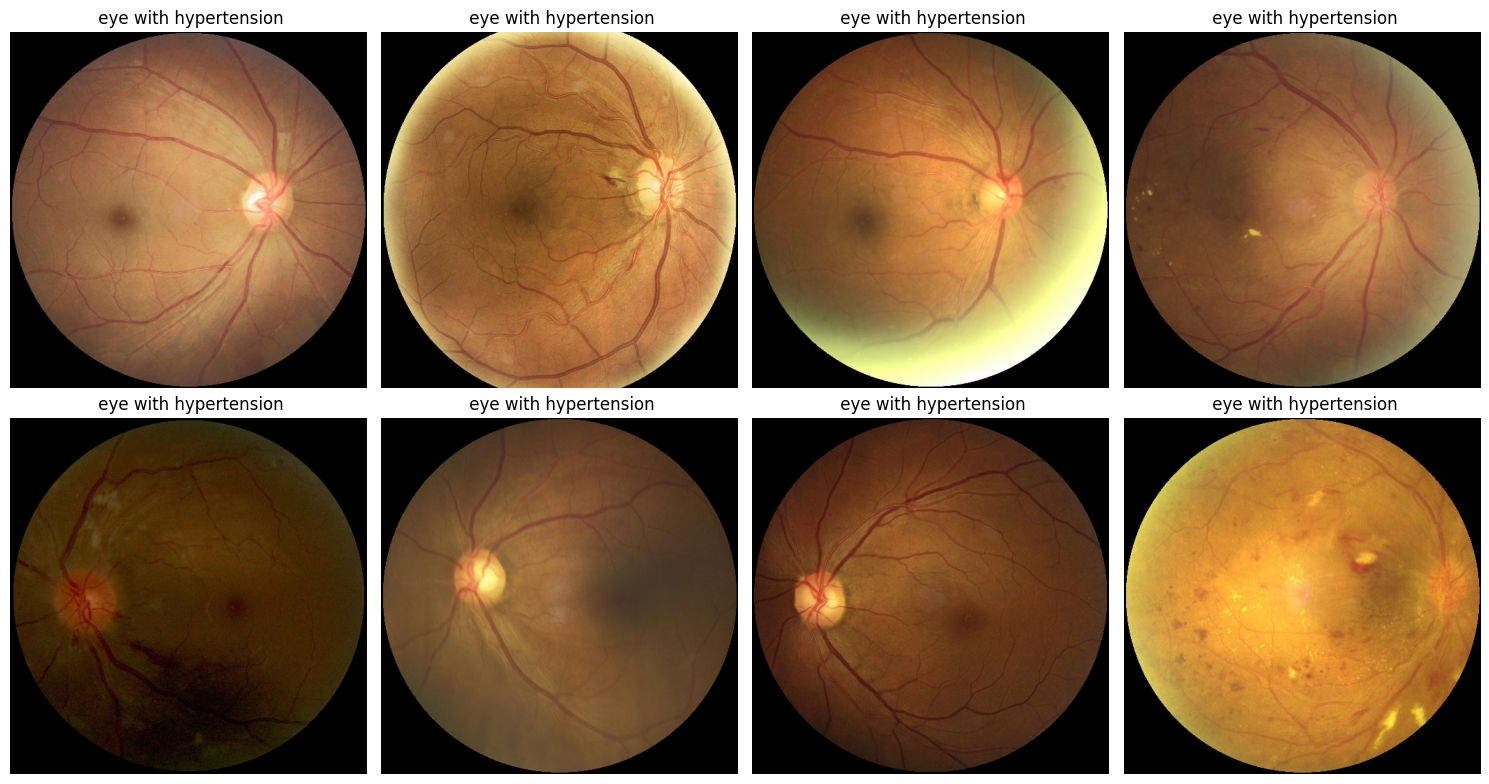

In [ ]:
fig , axs = plt.subplots( 2 , 4 , figsize = ( 15 , 8))

axs = axs.flatten()

indices = random.sample(range(len(hypertension_images)) , 8 )

for i  , idx in enumerate( indices) :
  kk = hypertension_images[idx]
  impath = os.path.join( dataset_dir , kk )

  # Load the image using OpenCV
  image = cv2.imread(impath)
  # Convert BGR to RGB (matplotlib expects RGB, OpenCV reads BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  axs[i].imshow( image )
  axs[i].set_title( " eye with hypertension")
  axs[i].axis( "off")

plt.tight_layout()
plt.show()

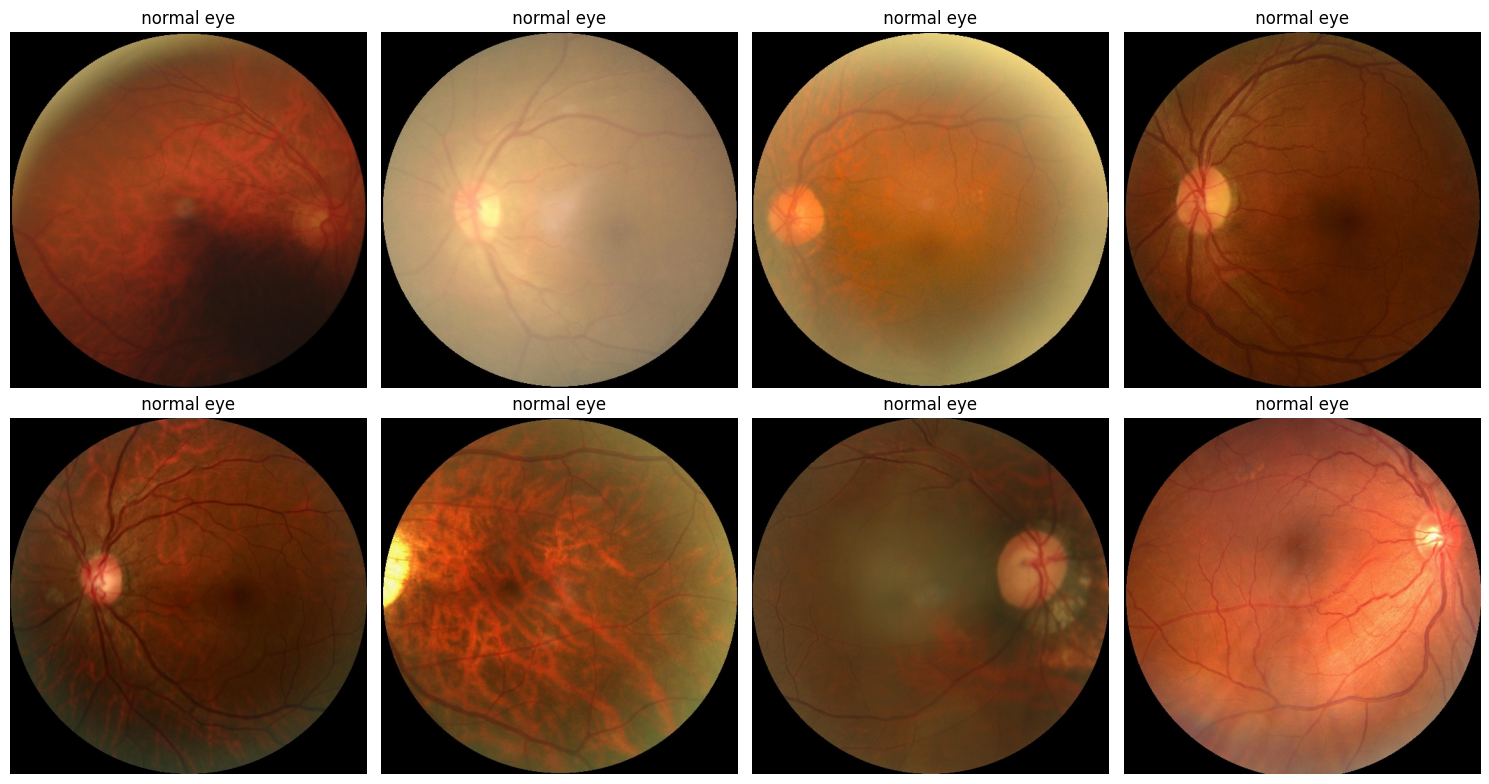

In [ ]:
fig , axs = plt.subplots( 2 , 4 , figsize = ( 15 , 8))

axs = axs.flatten()

indices = random.sample(range(len(normal_images)) , 8 )

for i  , idx in enumerate( indices) :
  kk = normal_images[idx]
  impath = os.path.join( dataset_dir , kk )

  # Load the image using OpenCV
  image = cv2.imread(impath)
  # Convert BGR to RGB (matplotlib expects RGB, OpenCV reads BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  axs[i].imshow( image )
  axs[i].set_title( " normal eye ")
  axs[i].axis( "off")

plt.tight_layout()
plt.show()

---
## VIEWING THE IMAGES ,ALONG WITH THE LABELS

[562, 541, 484, 445, 458, 181, 689, 320]


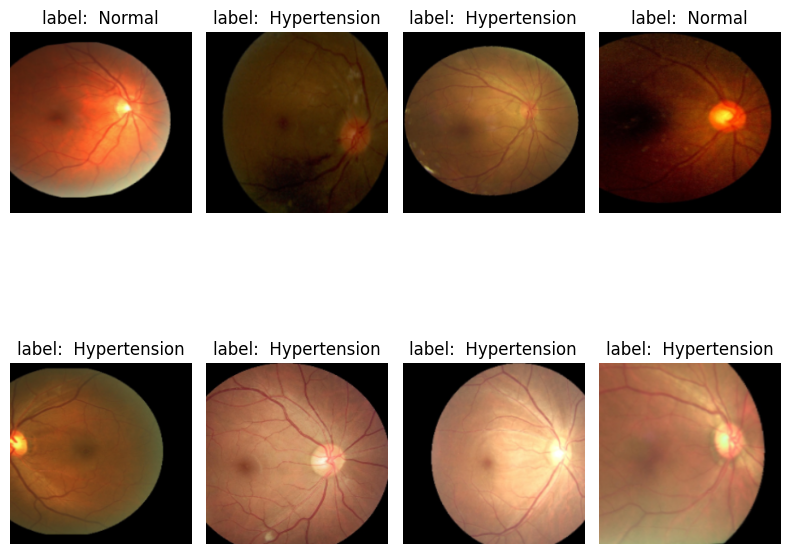

In [ ]:
# the  datasets are  - training_dataset   , val_dataset
# the dataloaders are - train_loader , val_loader

# dataset_dir opens in preprocessed images


# selecting random indices from the dataset
indices  = random.sample(range(len(training_dataset)), 8 )
fig , axs = plt.subplots( 2 , 4 , figsize = ( 8 , 8 ))

print( indices)
axs = axs.flatten()

# Unnormalize
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

for i , idx in enumerate( indices ) :
  image , label = training_dataset[idx]


  #unnormalize
  image = image * std[:, None, None] + mean[:, None, None]
  image = image.permute(1, 2, 0).clamp(0, 1)

  if label == 1 :
    jj = " Hypertension"
  else :
    jj = " Normal"

  axs[i].imshow( image )
  axs[i].set_title( f"label: { jj}")
  axs[i].axis( "off")


plt.tight_layout()
plt.show()
